# Main Implementation

In [3]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
#?

## Training and testing model

In [4]:
data = np.load('fashion_train.npy')
X = data[:,:-1]
Y = data[:,-1]
test = np.load('fashion_test.npy')
xtest = test[:,:-1]
ytest = test[:,-1]

In [ ]:
#?

### Testing performance of library tree implementation (at different depths)

In [6]:
import random

X = data[:, :-1]  # Features (784 pixel values)
Y = data[:, -1]   # Labels
def k_foldscv(X, y, k, depth):
    seq = [x for x in range(len(X))]
    acc = []
    acc2 = []
    
    for i in range(k):
        rows = random.sample(seq, int(len(X) / k))

        k_folds_v = X[rows].copy()  # Validation set
        k_folds_t = np.delete(X, rows, axis=0)  # Training set features
        y_folds_t = np.delete(y, rows, axis=0) 
        y_folds_v = y[rows]  # Validation set labels

        TREE = DecisionTreeClassifier(max_depth=depth) 
        TREE.fit(k_folds_t, y_folds_t)
        prediction = TREE.predict(k_folds_v)
        pred2 = TREE.predict(k_folds_t)
        accuracy = accuracy_score(y_folds_v, prediction)
        ac2 = accuracy_score(y_folds_t, pred2)
        acc.append(accuracy)
        acc2.append(ac2)
    
    return acc, acc2

train_avgs = []
avgs = []
for depth in range(2, 15):
    accuracy, ac2 = k_foldscv(X, Y, 10, depth)
    avgs.append(accuracy)
    train_avgs.append(ac2)

avgs, train_avgs


([[0.53, 0.526, 0.537, 0.532, 0.523, 0.548, 0.536, 0.544, 0.529, 0.519],
  [0.726, 0.72, 0.751, 0.755, 0.721, 0.755, 0.718, 0.752, 0.722, 0.726],
  [0.764, 0.737, 0.745, 0.762, 0.725, 0.776, 0.746, 0.766, 0.763, 0.758],
  [0.78, 0.783, 0.781, 0.778, 0.805, 0.775, 0.761, 0.798, 0.767, 0.77],
  [0.802, 0.821, 0.806, 0.797, 0.838, 0.802, 0.781, 0.804, 0.801, 0.804],
  [0.811, 0.804, 0.806, 0.818, 0.787, 0.805, 0.798, 0.771, 0.8, 0.786],
  [0.805, 0.798, 0.804, 0.808, 0.797, 0.808, 0.83, 0.797, 0.805, 0.794],
  [0.799, 0.787, 0.802, 0.802, 0.822, 0.825, 0.801, 0.829, 0.79, 0.799],
  [0.781, 0.799, 0.836, 0.794, 0.792, 0.811, 0.82, 0.809, 0.795, 0.773],
  [0.798, 0.816, 0.788, 0.78, 0.795, 0.785, 0.792, 0.801, 0.789, 0.814],
  [0.779, 0.806, 0.791, 0.791, 0.787, 0.803, 0.795, 0.807, 0.772, 0.8],
  [0.772, 0.785, 0.795, 0.81, 0.787, 0.787, 0.788, 0.788, 0.777, 0.799],
  [0.768, 0.807, 0.795, 0.821, 0.807, 0.778, 0.784, 0.796, 0.777, 0.805]],
 [[0.5457777777777778,
   0.5441111111111111,
   0

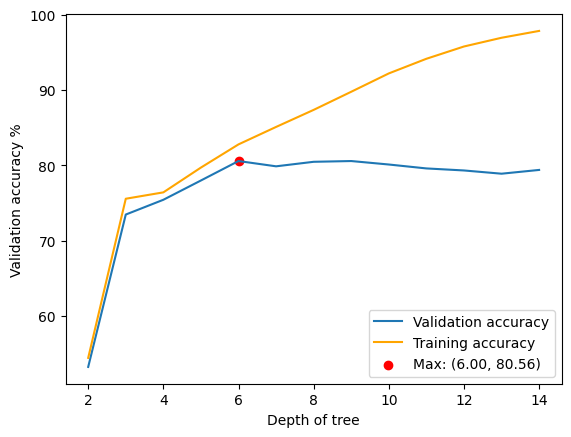

[53.239999999999995, 73.46, 75.42, 77.98000000000002, 80.56, 79.86000000000001, 80.46000000000001, 80.56, 80.1, 79.58000000000001, 79.31, 78.88000000000001, 79.38]


In [11]:
avg_acc = [np.mean(i)*100 for i in avgs]
avg_acc_t = [np.mean(i)*100 for i in train_avgs]
plt.plot(range(2,15), avg_acc, label="Validation accuracy")
plt.plot(range(2,15), avg_acc_t, color="orange", label="Training accuracy")

#plt.title("Validation Accuracy for depths 2-15")
plt.xlabel("Depth of tree")
plt.ylabel("Validation accuracy %")
max_y = np.max(avg_acc)
max_x = 6

plt.scatter(max_x, max_y, color='red', label=f'Max: ({max_x:.2f}, {max_y:.2f})')
plt.legend(loc='lower right')
#plt.ylim((77,84))
plt.show()

print(avg_acc)

**Random forest** (most important feature evaluation):

In [5]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(data[:,:-1], data[:,-1])
imp = rnd_clf.feature_importances_

(-0.5, 27.5, 27.5, -0.5)

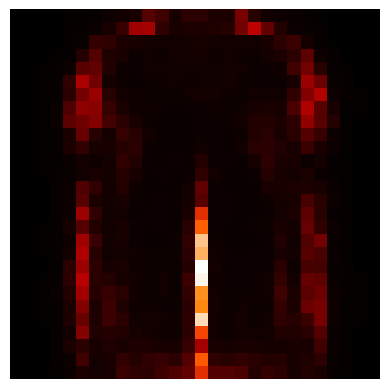

In [20]:
imp = (imp - np.min(imp)) / (np.max(imp) - np.min(imp))
imp = imp.reshape((28,28))

plt.imshow(imp, cmap='gist_heat', vmin=0, vmax=1)
plt.axis('off')

In [24]:
forestpredict = rnd_clf.predict(xtest)
f"{accuracy_score(ytest, forestpredict)*100}% accuracy"

'85.39999999999999% accuracy'

(Probably delete) Testing library tree with varying PC's and depth

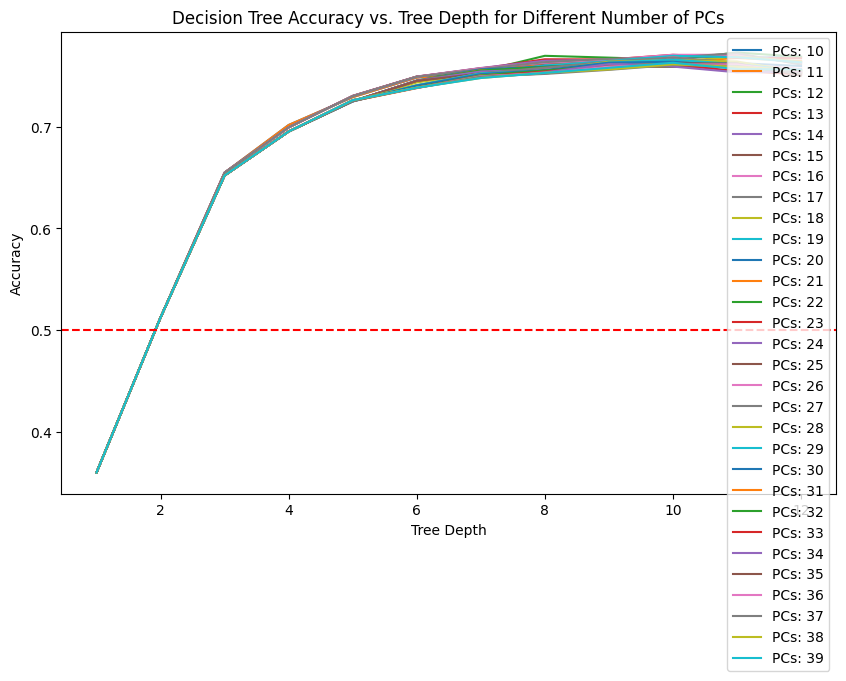

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Prepare your data
X = data[:, :-1]  # Features (784 pixel values)
Y = data[:, -1]   # Labels

X_test = test[:, :-1]
Y_test = test[:, -1]

# Store results for plotting
accuracy_results = []

# Loop over the number of principal components
for n_components in range(10, 40):
    # Step 1: Fit PCA with `n_components`
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X)  # Fit and transform training data
    X_test_pca = pca.transform(X_test)  # Transform test data

    # Store accuracies for each depth
    acc_for_depths = []

    # Loop over the depth of the tree
    for depth in range(1, 13):  # Adjust the range for depth as needed
        tree_clf = DecisionTreeClassifier(max_depth=depth)
        tree_clf.fit(X_train_pca, Y)  # Train the model on PCA-transformed data

        # Make predictions on the PCA-transformed test data
        Y_pred = tree_clf.predict(X_test_pca)

        # Calculate the accuracy of the model
        accuracy = accuracy_score(Y_test, Y_pred)
        acc_for_depths.append(accuracy)

    # Append the accuracies for the current number of components
    accuracy_results.append(acc_for_depths)

# Convert results to a NumPy array for easier indexing
accuracy_results = np.array(accuracy_results)

# Plot the accuracy results for different tree depths for each number of principal components
plt.figure(figsize=(10, 6))
for i in range(accuracy_results.shape[0]):
    plt.plot(range(1, 13), accuracy_results[i], label=f'PCs: {i + 10}')  # +10 to adjust for PC count

plt.axhline(y=0.5, color='red', linestyle='--')  # Example horizontal line at 50% accuracy
plt.title("Decision Tree Accuracy vs. Tree Depth for Different Number of PCs")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()